# Forewords

Demo for exploring mutations impact with Pysster trained models.

# Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import pyfaidx
import sys
import importlib
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "../src/"
if not path in sys.path:
    sys.path.insert(0, path)

import lib_model_pysster
from lib_model_pysster import ModelPysster, integrate_gradient_model_from_nucleotide_seq

# Load

In [3]:
filepath_model = Path("../example_data/pysster_model.QKI_HepG2.pkl.h5")

model_struct = ModelPysster.load_from_path(filepath_model)

model_struct.model.summary()
print(f"Number of output scores for a given input: {model_struct.model.output_shape[1]}")

# Human-interpretable labels, which depend on how you trained your models.
pysster_scores_labels = ["class_0:positive", "class_1:negative","class_2:other_rbp"][:model_struct.model.output_shape[1]]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2024-11-07 20:54:33.940207: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-11-07 20:54:33.962646: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3293800000 Hz
2024-11-07 20:54:33.964138: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558cf5428840 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-11-07 20:54:33.964173: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 4)]          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 383, 150)          10950     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 191, 150)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 191, 150)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 174, 150)          405150    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 87, 150)           0   

In [4]:
main_human_chroms = [f"chr{i}" for i in range(1,23)] + ["chrX", "chrY"]

path = "../example_data/hg38.chrom.sizes"
hg38_chromsizes = pd.read_csv(path, header=None, index_col=None, sep="\t", names=["chr", "size"]).set_index('chr')['size'].to_dict()

fasta_path = "../example_data/hg38.chr21.fa.gz"
fa = pyfaidx.Faidx(str(fasta_path))

# Note: this can be used as a context-manager too.
with pyfaidx.Faidx(str(fasta_path)) as cm_fa:
    # NOTE: specific to this library : the coordinates should be 1-based, close-ended, i.e. [1, 1] returns the "first" base.
    seq_fetched = str(cm_fa.fetch("chr21", 33_031_601, 33_032_000))
    assert (len(seq_fetched) == 400)

In [5]:
encore_peaks_columns = ["chrom","start","end","name","score","strand","signal_value","p_value","q_value","peak"]
peaks = pd.read_csv("../example_data/QKI_HepG2.chr21_example_narrow_peaks.ENCFF815XNW.bed.gz", header=None, index_col=None, sep="\t", names=encore_peaks_columns)

# Score peaks and demo integrated gradients

In [6]:
intervals = []
sequences = []
scores = []
igs = []

for i, row in peaks.iterrows():
    # Note: eCLIP peaks' 5prime end is a better location of the RBP binding site than the peak center.
    # We extract here intervals of 400bp centered around the 5' end of the peak.
    # Note: this is to be adapted for minus strand sequences (along with taking the reverse complement).
    start = row['start'] - 200 +1
    end = row['start'] + 200 # do not forget : 1-based interval query ; while the BED is 0-based by convention.
    if start < 0 or end >= hg38_chromsizes[row['chrom']]:
        continue

    interval = f"{row['chrom']}:{start}-{end}:+"
    seq = str(fa.fetch(row['chrom'], start, end)).upper()

    intervals.append(interval)
    sequences.append(seq)
    scores.append(pd.Series(model_struct.predict_window(seq)[0], index=pysster_scores_labels))
    igs.append(integrate_gradient_model_from_nucleotide_seq(seq=seq, model_structure=model_struct, target_class_idx=0))

In [7]:
display(pd.DataFrame(scores))

,class_0:positive,class_1:negative,class_2:other_rbp
0,0.879401,0.103231,0.017368
1,0.981071,0.006731,0.012198
2,0.988384,0.009994,0.001621
3,0.940453,0.039007,0.020540
4,0.900970,0.076048,0.022983
5,0.860264,0.048668,0.091068
6,0.933775,0.032580,0.033645
7,0.993059,0.003886,0.003054
8,0.957478,0.027458,0.015064
9,0.970361,0.019272,0.010367


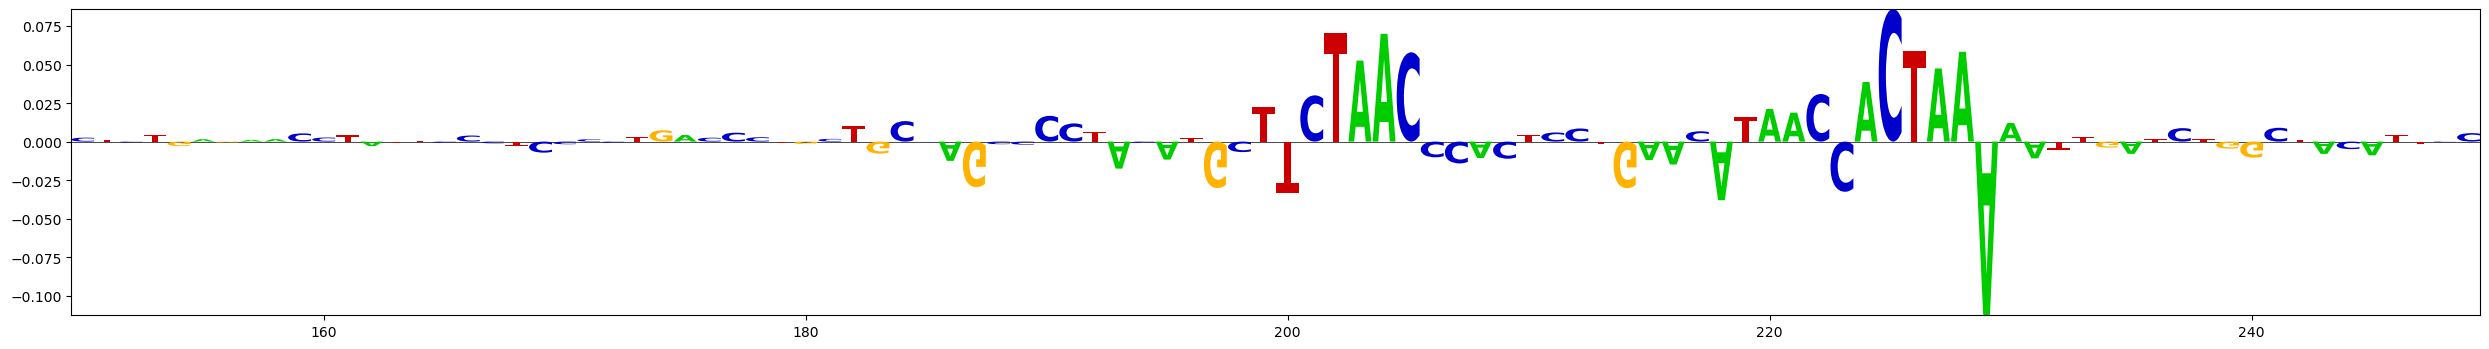

In [9]:
# Here we can plot the integrated gradients for the first sequence.
# We can "zoom in" the core 100nt region of the 400nt sequence to better show the motif(s).
igs[0].plot_logo(start_end = [150, 250])

# Single Nucleotide Mutation

## Single-point mutation demo

In [24]:
seq_ref = sequences[0]
# From manual exploration of the sequence: do a T>G mutation.
seq_alt = seq_ref[:202] + "G" + seq_ref[203:]

score_alt = pd.Series(model_struct.predict_window(seq_alt)[0], index=pysster_scores_labels)
ig_alt = integrate_gradient_model_from_nucleotide_seq(seq=seq_alt, model_structure=model_struct, target_class_idx=0)

In [25]:
display(pd.DataFrame([scores[0], score_alt], index=["Ref", "Alt"]))

,class_0:positive,class_1:negative,class_2:other_rbp
Ref,0.879401,0.103231,0.017368
Alt,0.276107,0.611772,0.112121


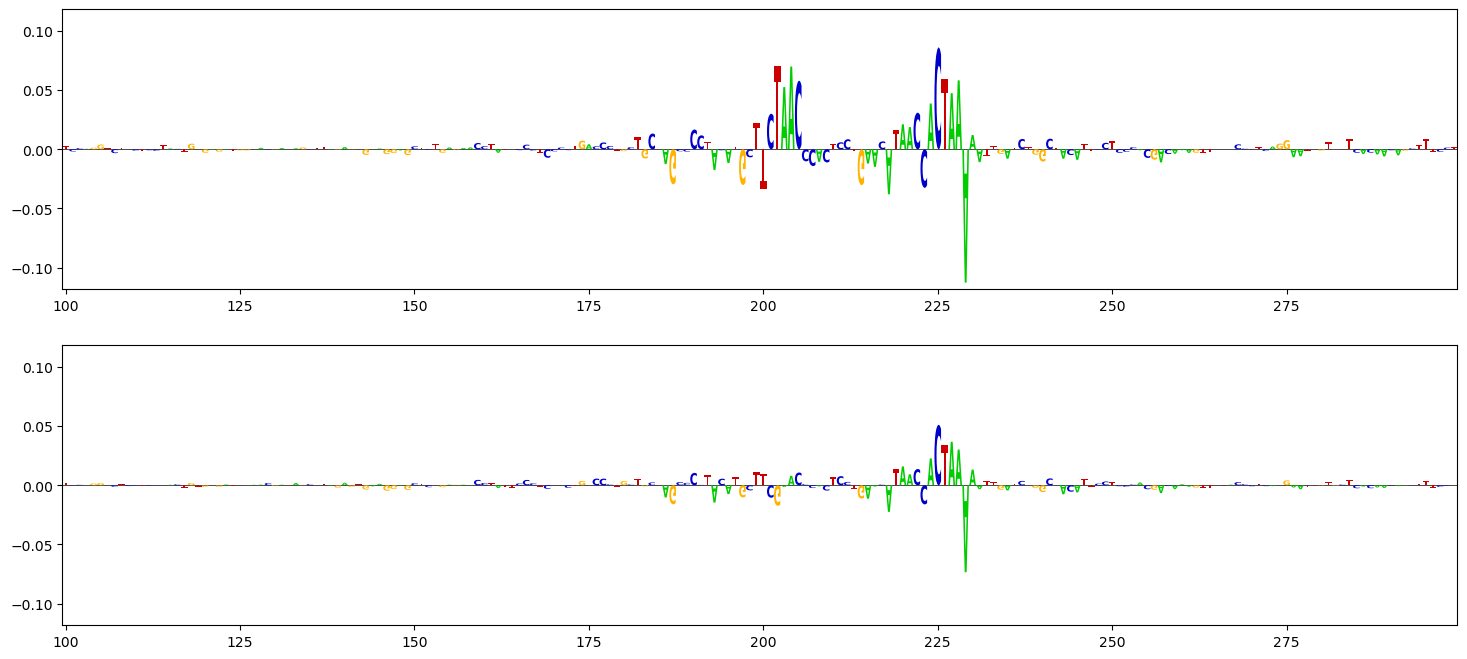

In [26]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)

ax1 = igs[0].plot_logo(start_end=(100,300), ax=ax1, show_plot=False)
ax2 = ig_alt.plot_logo(start_end=(100,300), ax=ax2, show_plot=False)

# Get absolute max y value across all three axes
y_max = max([max(map(abs, ax.get_ylim())) for ax in [ax1,ax2,]]) * 1.05

# Set the range of y values for all axes
for ax in [ax1,ax2,]:
    ax.set_ylim([-y_max,y_max])

plt.show()
